##### Importing library:

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import STL
from scipy import stats
from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize
from scipy.stats import gamma, shapiro

## 1. Read data

In [4]:
data = pd.read_csv('./data/prcp_monthly.csv').drop('index', axis=1)
data['month'] = pd.to_datetime(data['month'])
data.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')
data.head()

,month,prcp
2001-01-31,2001-01-01,101.4
2001-02-28,2001-02-01,98.2
2001-03-31,2001-03-01,201.2
2001-04-30,2001-04-01,141.2
2001-05-31,2001-05-01,33.3


## 2. EDA

#### 2.1. Plot time series

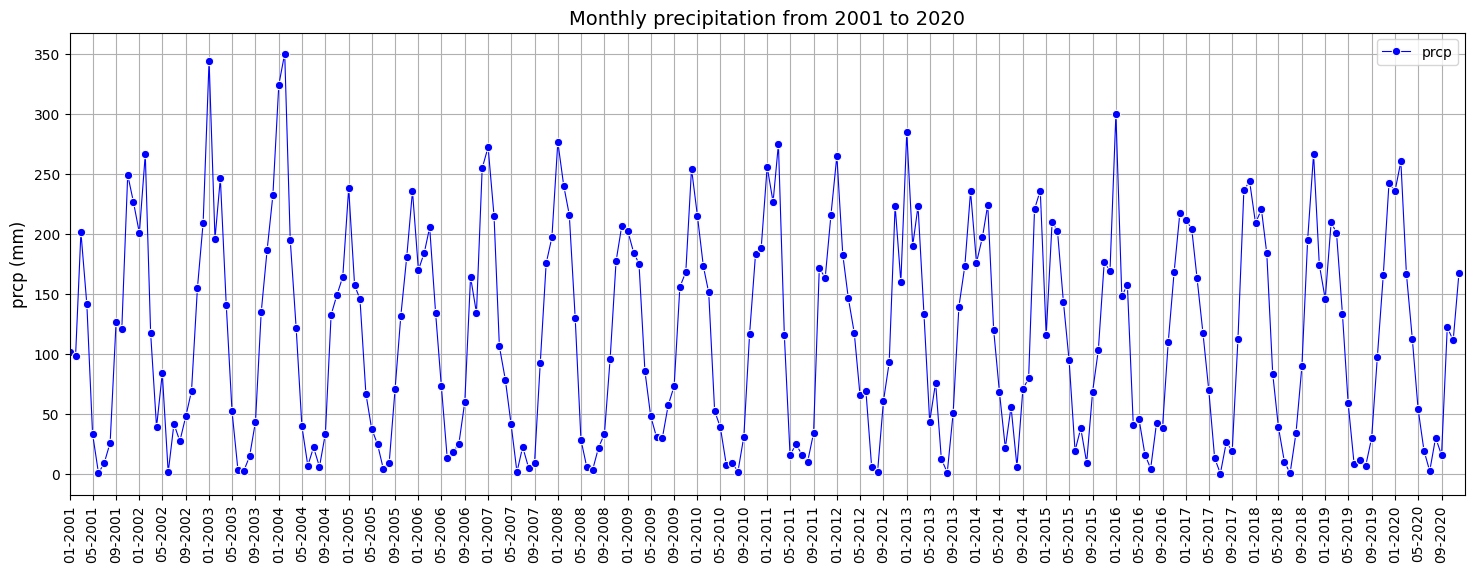

In [14]:
plt.figure(figsize=(18, 6))
sns.lineplot(x=data["month"], y=data["prcp"], label="prcp", color="b", linewidth=0.8, marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.title("Monthly precipitation from 2001 to 2020", fontsize=14)
plt.xlabel(None)
plt.ylabel("prcp (mm)", fontsize=12)
plt.grid(True)
# plt.savefig('pcrp_monthly.png')
plt.legend()

#### 2.2. Distribution

Using Gaussian Mixture Model:

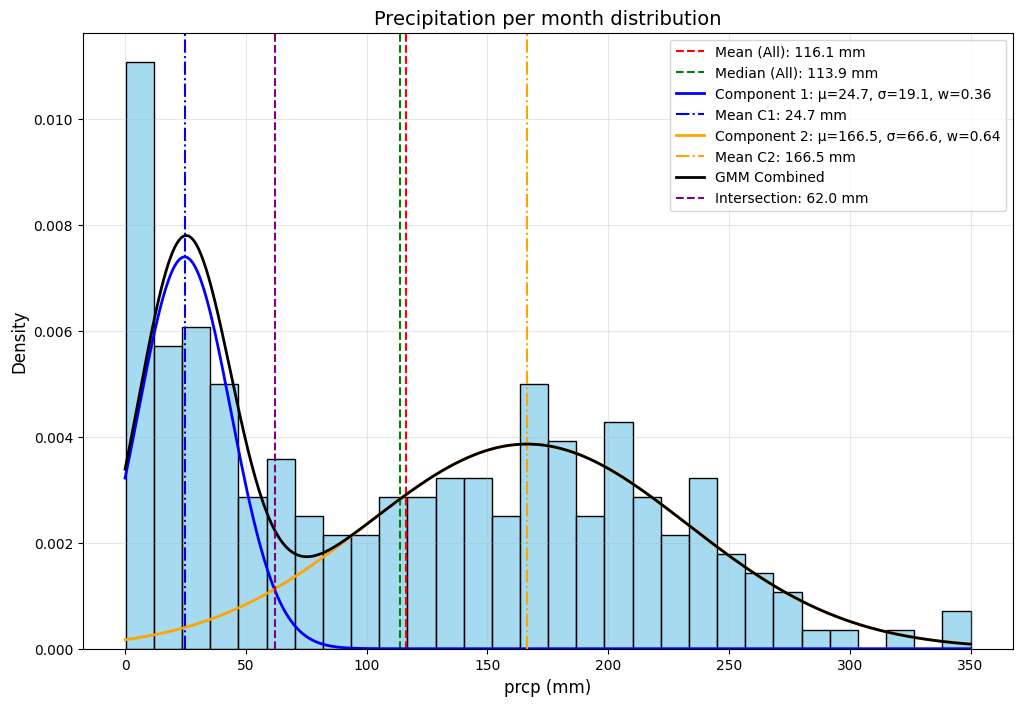

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(data['prcp'], bins=30, color='skyblue', stat='density')

plt.axvline(data['prcp'].mean(), color='red', linestyle='--', 
            label=f'Mean (All): {data["prcp"].mean():.1f} mm')

plt.axvline(data['prcp'].median(), color='green', linestyle='--', 
            label=f'Median (All): {data["prcp"].median():.1f} mm')

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data['prcp'].values.reshape(-1, 1))

means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())
weights = gmm.weights_

x = np.linspace(0, data['prcp'].max(), 1000)

colors = ['blue', 'orange']

# Vẽ hai đường Gaussian riêng biệt
for i in range(2):
    plt.plot(x, weights[i] * stats.norm.pdf(x, means[i], stds[i]), 
             color=colors[i],
             label=f'Component {i+1}: μ={means[i]:.1f}, σ={stds[i]:.1f}, w={weights[i]:.2f}',
             linewidth=2)
    
    plt.axvline(means[i], color=colors[i], linestyle='-.', 
                label=f'Mean C{i+1}: {means[i]:.1f} mm')

# Vẽ tổng hợp hai Gaussian
combined = np.zeros_like(x)
for i in range(2):
    combined += weights[i] * stats.norm.pdf(x, means[i], stds[i])
plt.plot(x, combined, 'k-', linewidth=2, label='GMM Combined')

# Tìm điểm giao nhau giữa hai phân phối
def find_intersection(x, means, stds, weights):
    pdf1 = weights[0] * stats.norm.pdf(x, means[0], stds[0])
    pdf2 = weights[1] * stats.norm.pdf(x, means[1], stds[1])
    diff = np.abs(pdf1 - pdf2)
    return x[np.argmin(diff)]

intersection_point = find_intersection(x, means, stds, weights)
plt.axvline(intersection_point, color='purple', linestyle='--', 
            label=f'Intersection: {intersection_point:.1f} mm')

plt.xlabel('prcp (mm)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Precipitation per month distribution', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('prcp_monthly_distribution_gaussian.png')
plt.show()

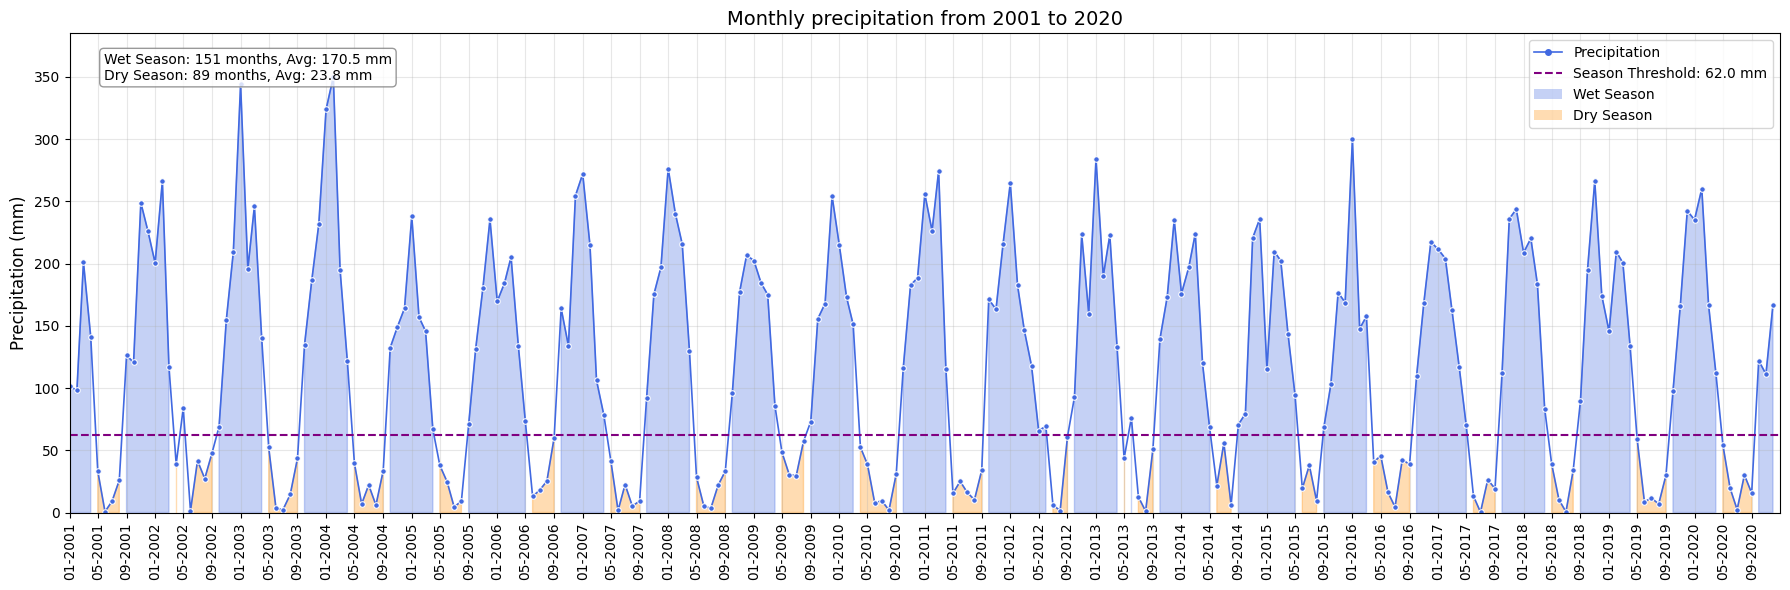

In [ ]:
plt.figure(figsize=(18, 6))

sns.lineplot(x=data["month"], y=data["prcp"], label="Precipitation", 
             color="royalblue", linewidth=1.2, marker='o', markersize=4)

# Thêm đường ngưỡng chuyển mùa
threshold = 62.0  # Sử dụng giá trị ngưỡng từ GMM
plt.axhline(y=threshold, color='purple', linestyle='--', linewidth=1.5,
            label=f'Season Threshold: {threshold:.1f} mm')

# Tạo mảng màu cho vùng mùa mưa và mùa khô
dates = data["month"]
values = data["prcp"]

# Tạo mask cho các điểm thuộc mùa mưa và mùa khô
wet_mask = values > threshold
dry_mask = values <= threshold

# Tô màu vùng mùa mưa (xanh lam nhạt)
plt.fill_between(dates, 0, values, where=wet_mask, 
                 color='royalblue', alpha=0.3, label='Wet Season')

# Tô màu vùng mùa khô (cam nhạt)
plt.fill_between(dates, 0, values, where=dry_mask, 
                 color='darkorange', alpha=0.3, label='Dry Season')

plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  


plt.title("Monthly precipitation from 2001 to 2020", fontsize=14)
plt.xlabel(None)
plt.ylabel("Precipitation (mm)", fontsize=12)
plt.grid(True, alpha=0.3)

ymax = max(data["prcp"]) * 1.1
plt.ylim(0, ymax)

custom_legend = [
    plt.Line2D([0], [0], color='royalblue', lw=1.2, marker='o', markersize=4, label='Precipitation'),
    plt.Line2D([0], [0], color='purple', lw=1.5, linestyle='--', label=f'Season Threshold: {threshold:.1f} mm'),
    plt.Rectangle((0,0), 1, 1, fc='royalblue', alpha=0.3, label='Wet Season'),
    plt.Rectangle((0,0), 1, 1, fc='darkorange', alpha=0.3, label='Dry Season')
]

wet_months_count = wet_mask.sum()
dry_months_count = dry_mask.sum()
wet_avg = values[wet_mask].mean()
dry_avg = values[dry_mask].mean()

plt.legend(handles=custom_legend, loc='upper right')

stats_text = (
    f"Wet Season: {wet_months_count} months, Avg: {wet_avg:.1f} mm\n"
    f"Dry Season: {dry_months_count} months, Avg: {dry_avg:.1f} mm"
)
plt.annotate(stats_text, xy=(0.02, 0.96), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             fontsize=10, ha='left', va='top')

plt.tight_layout()
# plt.savefig('precipitation_seasons_gaussian.png', dpi=300)
plt.show()

Using Gamma Mixture Model:

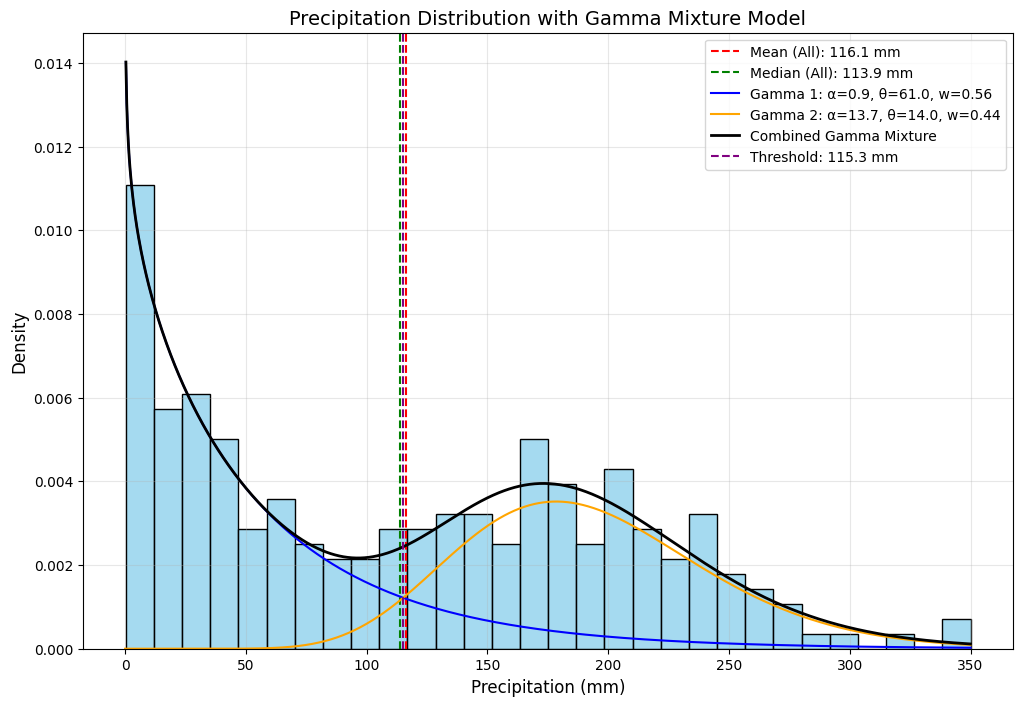


Gamma Mixture Model Parameters:
Component 1: α=0.90, θ=61.05, weight=0.56
Component 2: α=13.72, θ=14.03, weight=0.44
Seasonal Threshold: 115.3 mm


In [13]:
def gamma_mixture_pdf(x, params):
    w1, a1, scale1, a2, scale2 = params
    return w1 * gamma.pdf(x, a=a1, scale=scale1) + (1-w1) * gamma.pdf(x, a=a2, scale=scale2)

def negative_log_likelihood(params, data):
    return -np.sum(np.log(gamma_mixture_pdf(data, params)))

# Vẽ histogram
plt.figure(figsize=(12, 8))
sns.histplot(data['prcp'], bins=30, color='skyblue', stat='density')

# Thêm mean và median
plt.axvline(data['prcp'].mean(), color='red', linestyle='--', 
            label=f'Mean (All): {data["prcp"].mean():.1f} mm')
plt.axvline(data['prcp'].median(), color='green', linestyle='--', 
            label=f'Median (All): {data["prcp"].median():.1f} mm')

# Fit hỗn hợp phân phối Gamma
# Initial guess cho parameters
initial_params = [0.5, 2, 20, 4, 40]
bounds = [(0,1), (0,None), (0,None), (0,None), (0,None)]

result = minimize(negative_log_likelihood, initial_params, args=(data['prcp']),
                 bounds=bounds, method='L-BFGS-B')

w1, a1, scale1, a2, scale2 = result.x

# Vẽ các thành phần và đường tổng hợp
x = np.linspace(0, data['prcp'].max(), 1000)
plt.plot(x, w1 * gamma.pdf(x, a=a1, scale=scale1), 'b-', 
         label=f'Gamma 1: α={a1:.1f}, θ={scale1:.1f}, w={w1:.2f}')
plt.plot(x, (1-w1) * gamma.pdf(x, a=a2, scale=scale2), 'orange', 
         label=f'Gamma 2: α={a2:.1f}, θ={scale2:.1f}, w={1-w1:.2f}')

combined = gamma_mixture_pdf(x, result.x)
plt.plot(x, combined, 'k-', linewidth=2, label='Combined Gamma Mixture')

# Tìm điểm giao nhau
intersection_idx = np.argmin(np.abs(w1 * gamma.pdf(x, a=a1, scale=scale1) - 
                                  (1-w1) * gamma.pdf(x, a=a2, scale=scale2)))
threshold = x[intersection_idx]
plt.axvline(threshold, color='purple', linestyle='--',
            label=f'Threshold: {threshold:.1f} mm')

plt.xlabel('Precipitation (mm)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Precipitation Distribution with Gamma Mixture Model', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('prcp_monthly_distribution_gamma.png')
plt.show()

# In thông tin về mô hình
print(f"\nGamma Mixture Model Parameters:")
print(f"Component 1: α={a1:.2f}, θ={scale1:.2f}, weight={w1:.2f}")
print(f"Component 2: α={a2:.2f}, θ={scale2:.2f}, weight={1-w1:.2f}")
print(f"Seasonal Threshold: {threshold:.1f} mm")

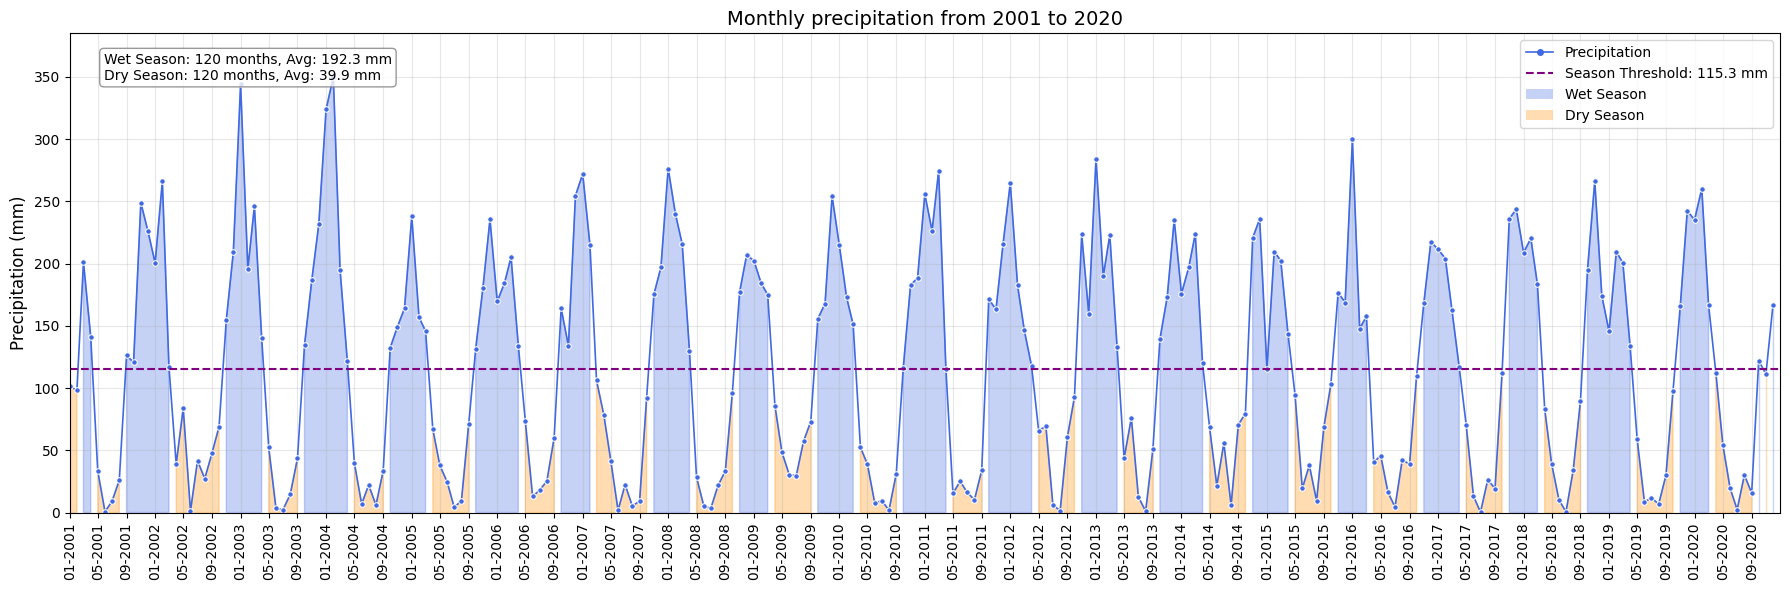

In [ ]:
plt.figure(figsize=(18, 6))

sns.lineplot(x=data["month"], y=data["prcp"], label="Precipitation", 
             color="royalblue", linewidth=1.2, marker='o', markersize=4)

# Thêm đường ngưỡng chuyển mùa
threshold = 115.3  # Sử dụng giá trị ngưỡng từ GMM
plt.axhline(y=threshold, color='purple', linestyle='--', linewidth=1.5,
            label=f'Season Threshold: {threshold:.1f} mm')

# Tạo mảng màu cho vùng mùa mưa và mùa khô
dates = data["month"]
values = data["prcp"]

# Tạo mask cho các điểm thuộc mùa mưa và mùa khô
wet_mask = values > threshold
dry_mask = values <= threshold

# Tô màu vùng mùa mưa (xanh lam nhạt)
plt.fill_between(dates, 0, values, where=wet_mask, 
                 color='royalblue', alpha=0.3, label='Wet Season')

# Tô màu vùng mùa khô (cam nhạt)
plt.fill_between(dates, 0, values, where=dry_mask, 
                 color='darkorange', alpha=0.3, label='Dry Season')

plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  


plt.title("Monthly precipitation from 2001 to 2020", fontsize=14)
plt.xlabel(None)
plt.ylabel("Precipitation (mm)", fontsize=12)
plt.grid(True, alpha=0.3)

ymax = max(data["prcp"]) * 1.1
plt.ylim(0, ymax)

custom_legend = [
    plt.Line2D([0], [0], color='royalblue', lw=1.2, marker='o', markersize=4, label='Precipitation'),
    plt.Line2D([0], [0], color='purple', lw=1.5, linestyle='--', label=f'Season Threshold: {threshold:.1f} mm'),
    plt.Rectangle((0,0), 1, 1, fc='royalblue', alpha=0.3, label='Wet Season'),
    plt.Rectangle((0,0), 1, 1, fc='darkorange', alpha=0.3, label='Dry Season')
]

wet_months_count = wet_mask.sum()
dry_months_count = dry_mask.sum()
wet_avg = values[wet_mask].mean()
dry_avg = values[dry_mask].mean()

plt.legend(handles=custom_legend, loc='upper right')

stats_text = (
    f"Wet Season: {wet_months_count} months, Avg: {wet_avg:.1f} mm\n"
    f"Dry Season: {dry_months_count} months, Avg: {dry_avg:.1f} mm"
)
plt.annotate(stats_text, xy=(0.02, 0.96), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             fontsize=10, ha='left', va='top')

plt.tight_layout()
# plt.savefig('precipitation_seasons_gamma.png', dpi=300)
plt.show()

#### 2.3. Trend Seasonal Decomposition

Traditional method:
- Additive model: T + S + E
- Not robust to noises and outliers

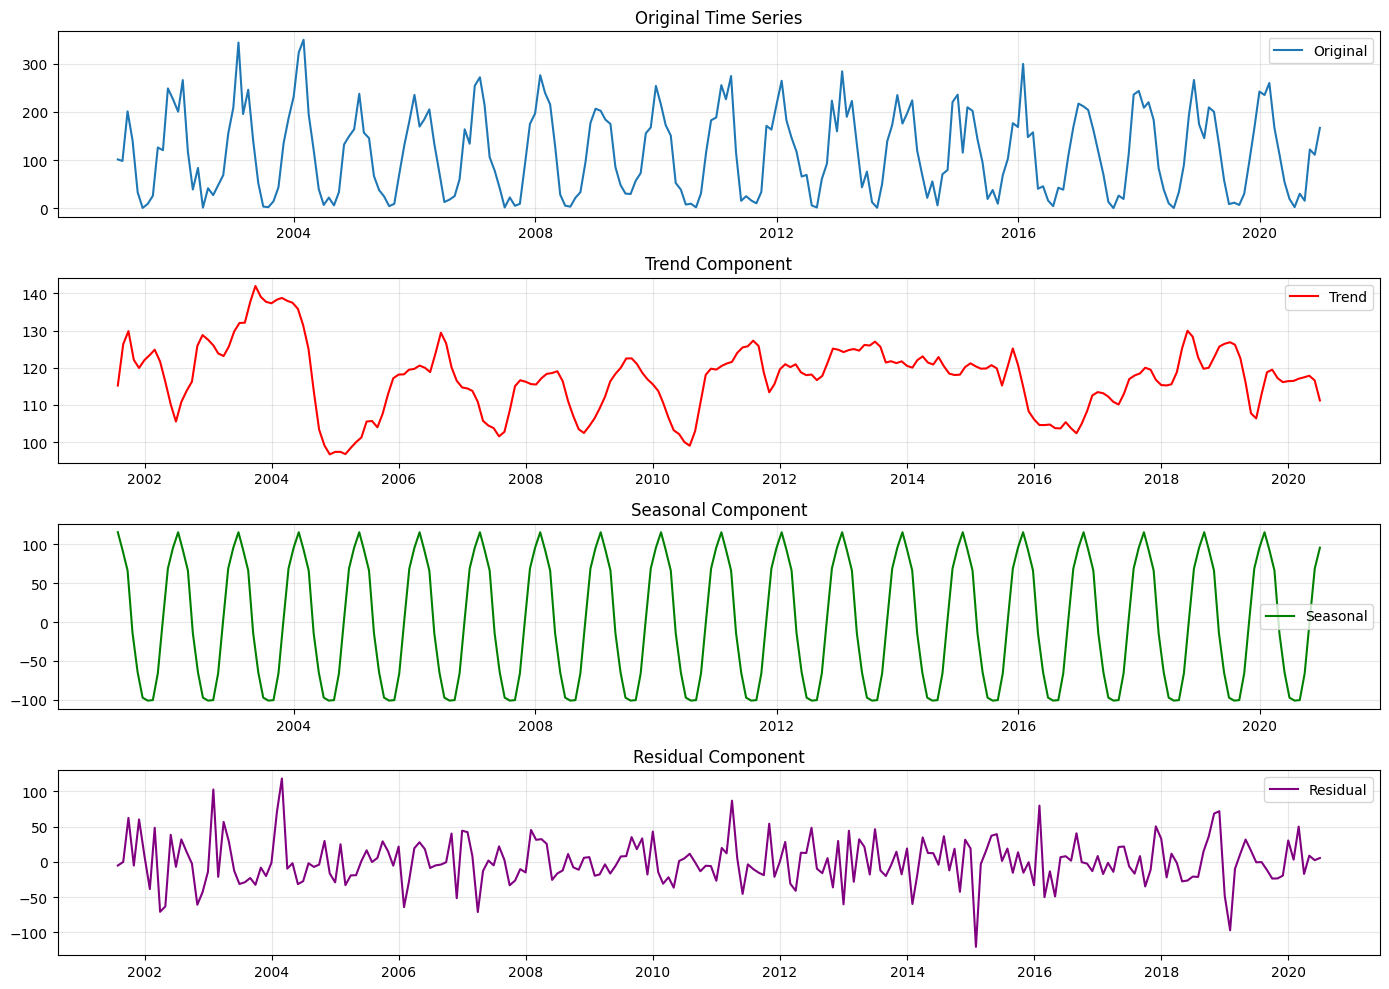

In [ ]:
seasonal_result = seasonal_decompose(data['prcp'], model='additive', period=12)

# Create a figure to display the decomposition results
plt.figure(figsize=(14, 10))

# Original data
plt.subplot(4, 1, 1)
plt.plot(data.index, data['prcp'], label='Original')
plt.title('Original Time Series')
plt.legend()
plt.grid(True, alpha=0.3)

# Trend component
plt.subplot(4, 1, 2)
plt.plot(data.index, seasonal_result.trend, label='Trend', c='r')
plt.title('Trend Component')
plt.legend()
plt.grid(True, alpha=0.3)

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(data.index, seasonal_result.seasonal, label='Seasonal', c='g')
plt.title('Seasonal Component')
plt.legend()
plt.grid(True, alpha=0.3)

# Residual component
plt.subplot(4, 1, 4)
plt.plot(data.index, seasonal_result.resid, label='Residual', c='purple')
plt.title('Residual Component')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('decomposition/seasonal_decompose_results.png', dpi=300)
plt.show()

STL:

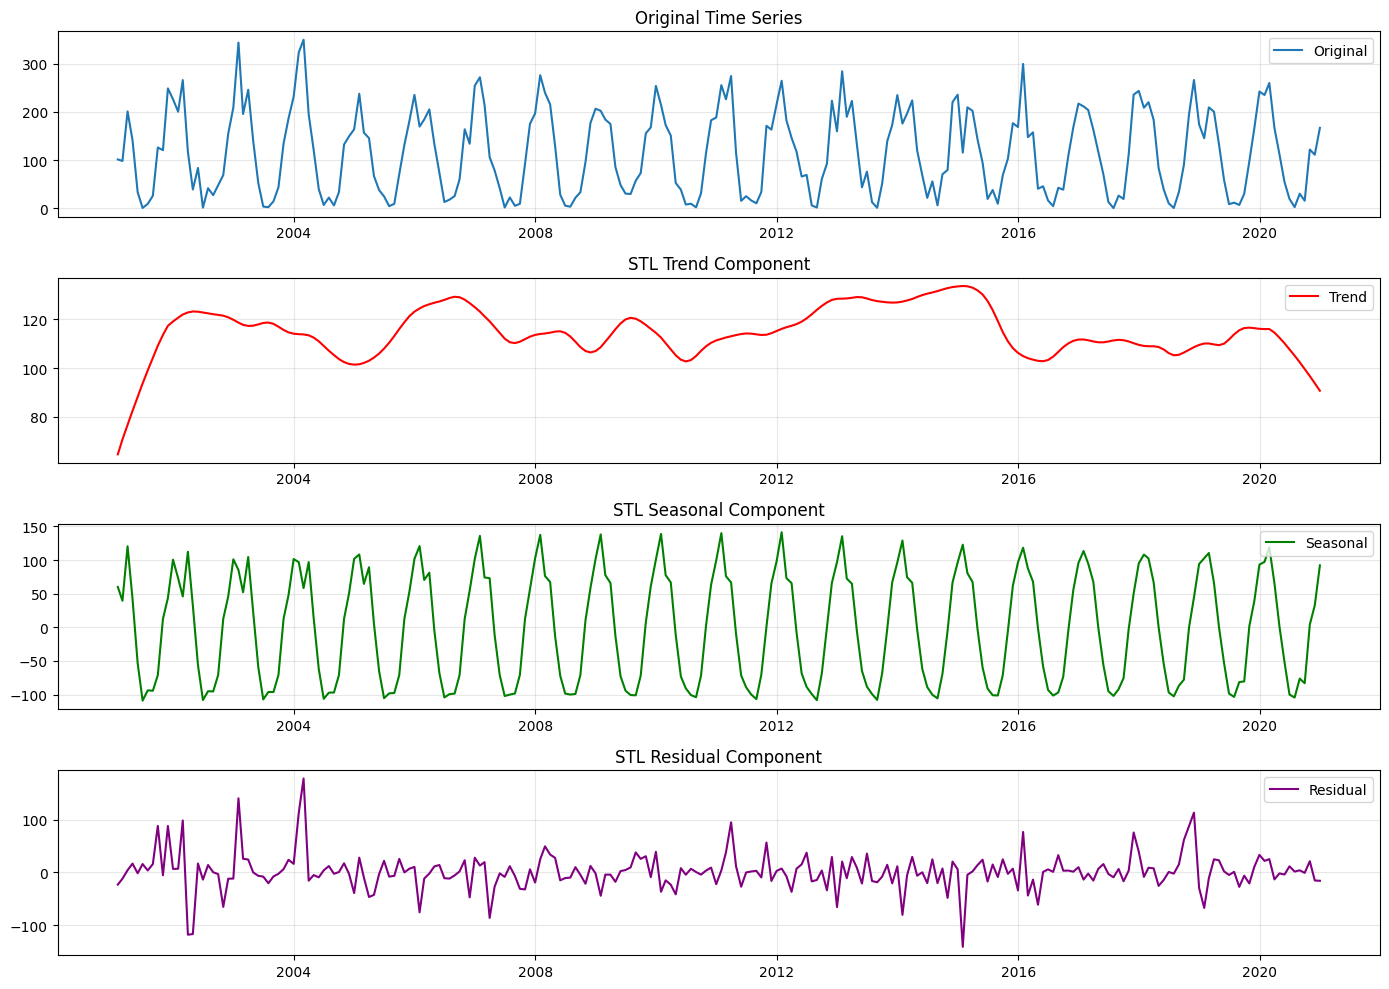

In [14]:
stl = STL(data['prcp'], 
          seasonal=13,  # Period length (slightly higher than 12 for flexibility)
          seasonal_deg=1,  # Degree of seasonal smoothing polynomial
          trend=21,  # Length of trend smoothing window
          robust=True)  # Using robust fitting to handle outliers
          
res_stl = stl.fit()

# Plot STL decomposition
plt.figure(figsize=(14, 10))

# Original data
plt.subplot(4, 1, 1)
plt.plot(data.index, data['prcp'], label='Original')
plt.title('Original Time Series')
plt.legend()
plt.grid(True, alpha=0.3)

# Trend component
plt.subplot(4, 1, 2)
plt.plot(data.index, res_stl.trend, label='Trend', color='red')
plt.title('STL Trend Component')
plt.legend()
plt.grid(True, alpha=0.3)

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(data.index, res_stl.seasonal, label='Seasonal', color='green')
plt.title('STL Seasonal Component')
plt.legend()
plt.grid(True, alpha=0.3)

# Residual component
plt.subplot(4, 1, 4)
plt.plot(data.index, res_stl.resid, label='Residual', color='purple')
plt.title('STL Residual Component')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('decomposition/stl_decomposition_results.png', dpi=300)
plt.show()

Comparision of two methods:

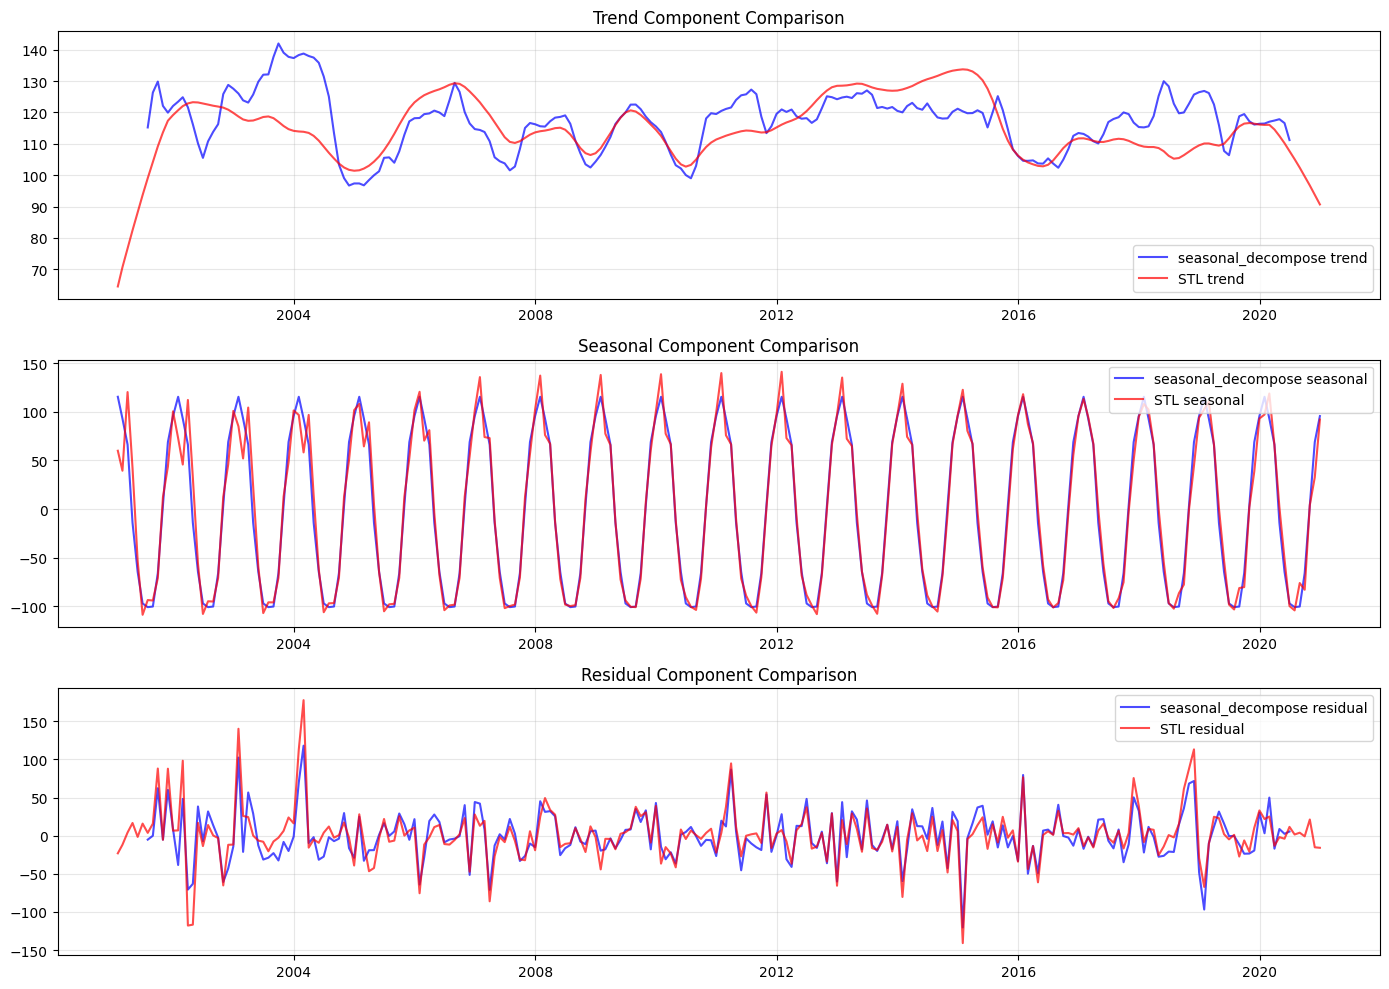

In [23]:
plt.figure(figsize=(14, 10))

# Compare trends
plt.subplot(3, 1, 1)
plt.plot(data.index, seasonal_result.trend, label='seasonal_decompose trend', color='blue', alpha=0.7)
plt.plot(data.index, res_stl.trend, label='STL trend', color='red', alpha=0.7)
plt.title('Trend Component Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare seasonal components
plt.subplot(3, 1, 2)
plt.plot(data.index, seasonal_result.seasonal, label='seasonal_decompose seasonal', color='blue', alpha=0.7)
plt.plot(data.index, res_stl.seasonal, label='STL seasonal', color='red', alpha=0.7)
plt.title('Seasonal Component Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare residuals
plt.subplot(3, 1, 3)
plt.plot(data.index, seasonal_result.resid, label='seasonal_decompose residual', color='blue', alpha=0.7)
plt.plot(data.index, res_stl.resid, label='STL residual', color='red', alpha=0.7)
plt.title('Residual Component Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('decomposition/decomposition_methods_comparison.png', dpi=300)
plt.show()

### 2.4. Check for stationary:

Intuitively:

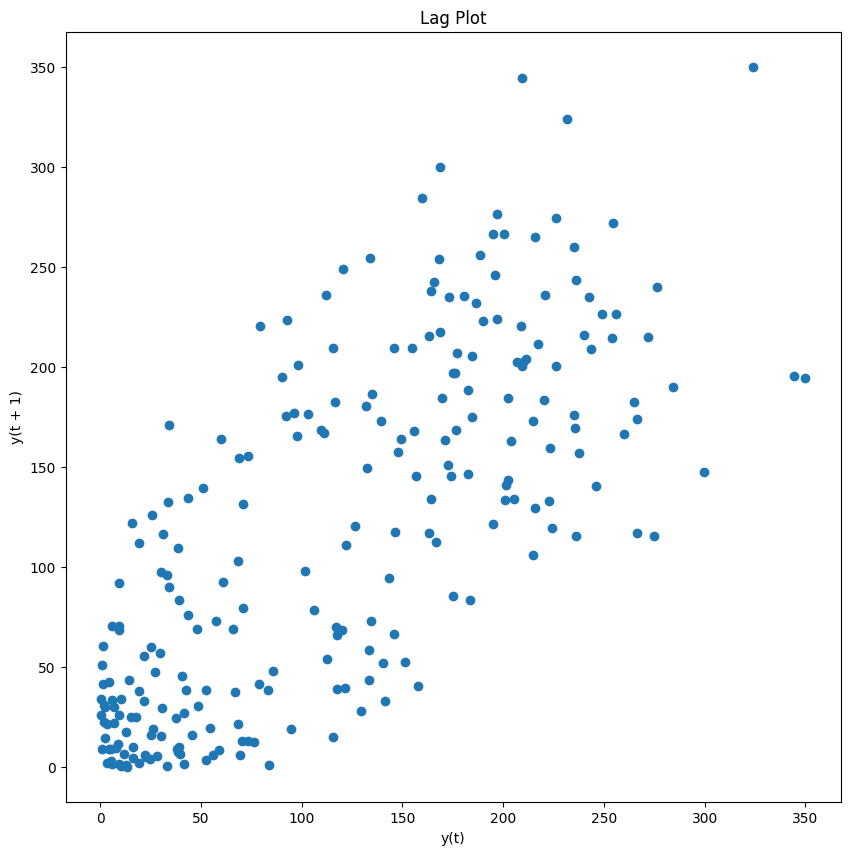

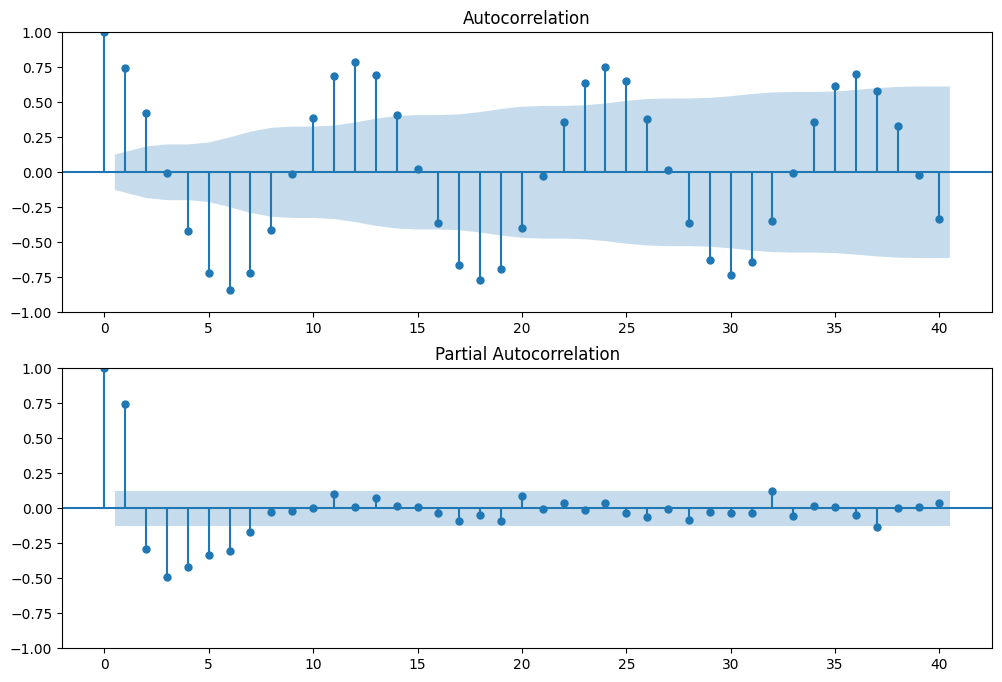

In [31]:
# 1.2 Lag Plot để kiểm tra tương quan
from pandas.plotting import lag_plot
plt.figure(figsize=(10, 10))
lag_plot(data['prcp'])
plt.title('Lag Plot')
plt.savefig('stationary_check/lag_plot.jpg')

# 1.3 ACF/PACF Plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data['prcp'], ax=ax1, lags=40)
plot_pacf(data['prcp'], ax=ax2, lags=40)
plt.savefig('stationary_check/acf_pacf.jpg')

Rolling std:

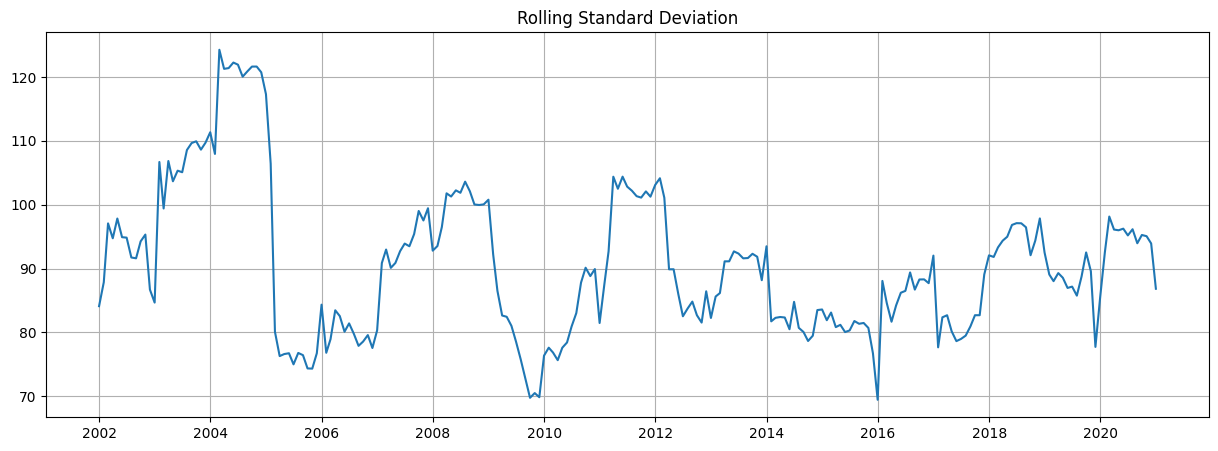

In [32]:
# Rolling standard deviation
rolling_std = data['prcp'].rolling(window=12).std()
plt.figure(figsize=(15, 5))
plt.plot(data.index, rolling_std)
plt.title('Rolling Standard Deviation')
plt.grid(True)
plt.savefig('stationary_check/rolling_std.jpg')

Augmented Dickey-Fuller Test: Seasonal Difference (period=12)
ADF Statistic          -6.302644e+00
p-value                 3.382585e-08
# Lags Used             1.200000e+01
# Observations          2.150000e+02
Critical Value (1%)    -3.461136e+00
Critical Value (5%)    -2.875079e+00
Critical Value (10%)   -2.573986e+00
Conclusion: Stationary



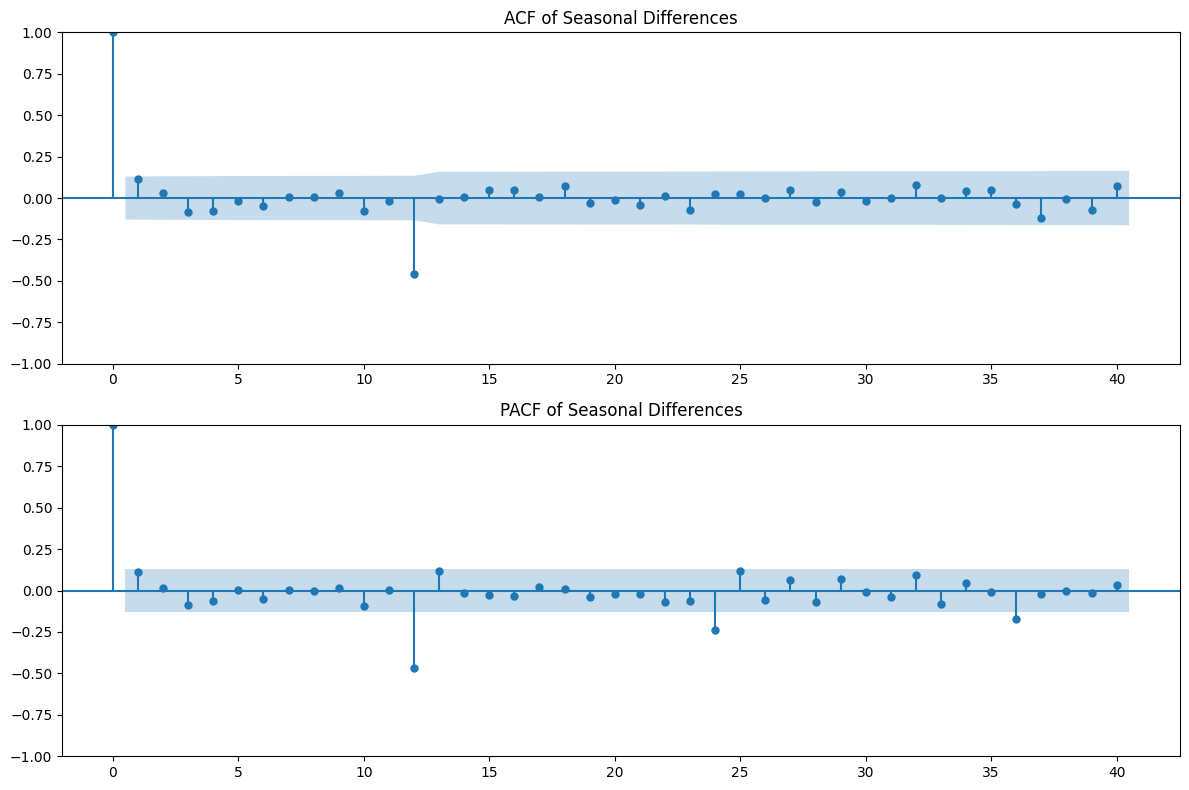

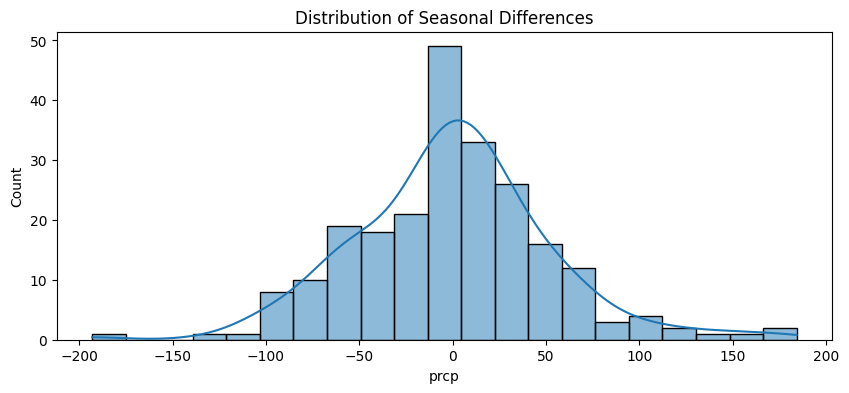

In [13]:
# Kiểm tra tính dừng theo mùa
def seasonal_stationarity_test(data, period=12):
    """
    Kiểm tra tính dừng theo mùa bằng cách:
    1. Tính sai phân mùa vụ
    2. Thực hiện ADF test
    3. Vẽ ACF của sai phân mùa vụ
    """
    # Tạo các lag mùa vụ
    seasonal_diffs = data - data.shift(period)
    seasonal_diffs = seasonal_diffs.dropna()
    
    # ADF test trên sai phân mùa vụ
    adf_test(seasonal_diffs, f'Seasonal Difference (period={period})')
    
    # Vẽ ACF và PACF của sai phân mùa vụ
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    plot_acf(seasonal_diffs, ax=ax1, lags=40)
    ax1.set_title('ACF of Seasonal Differences')
    
    plot_pacf(seasonal_diffs, ax=ax2, lags=40)
    ax2.set_title('PACF of Seasonal Differences')
    
    plt.tight_layout()
    plt.show()
    
    # Kiểm tra phân phối của sai phân mùa vụ
    plt.figure(figsize=(10, 4))
    sns.histplot(seasonal_diffs, kde=True)
    plt.title('Distribution of Seasonal Differences')
    plt.show()
    
    return seasonal_diffs

# Thực hiện kiểm định
seasonal_diffs = seasonal_stationarity_test(data['prcp'])

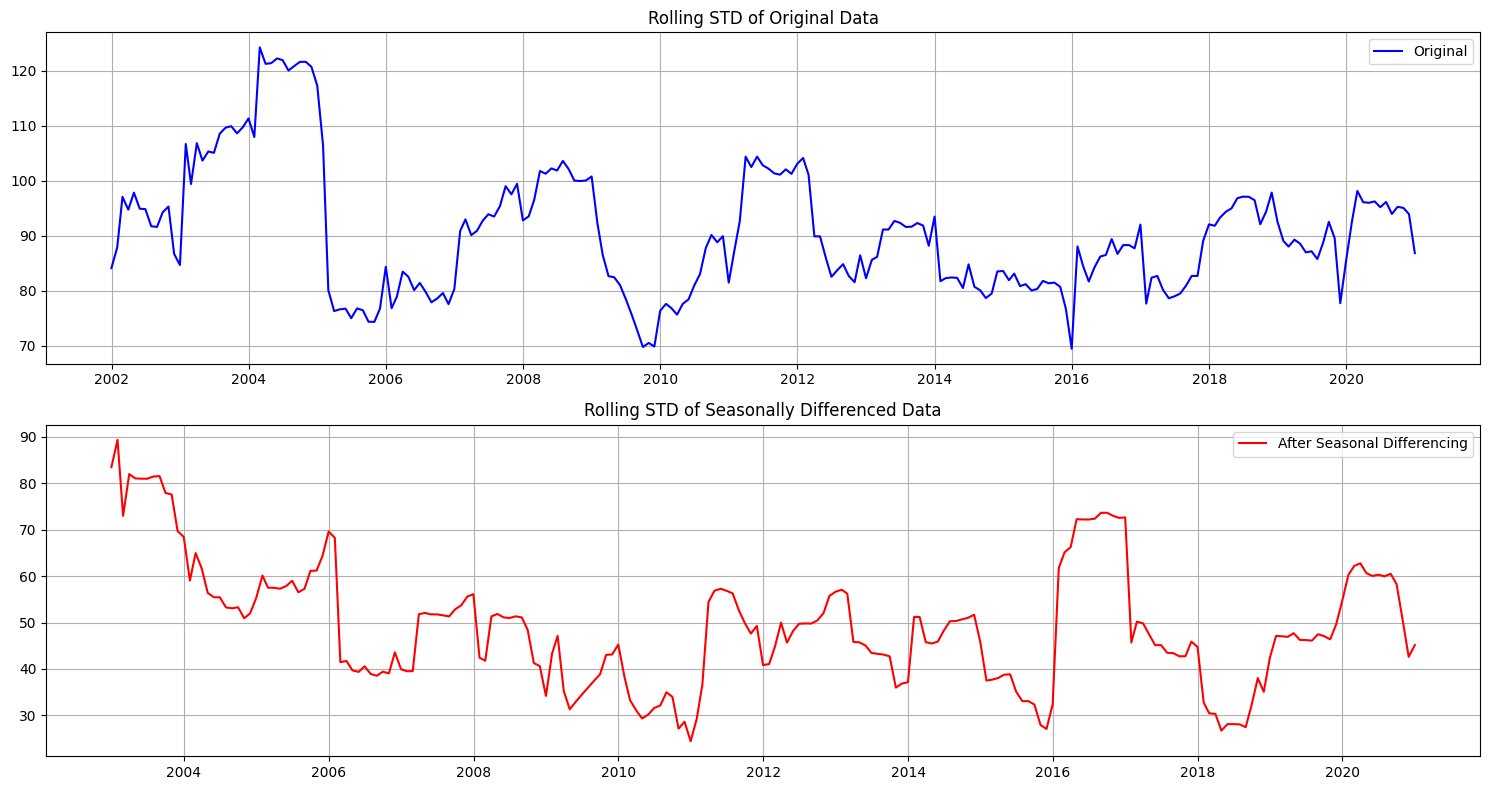


Rolling STD Summary:
Original - Mean: 90.54, STD: 11.47
After Differencing - Mean: 49.21, STD: 13.25


In [33]:
# Create a new cell and add this code:
# Calculate seasonal difference
seasonal_diff = data['prcp'] - data['prcp'].shift(12)
seasonal_diff = seasonal_diff.dropna()

# Plot comparison
plt.figure(figsize=(15, 8))

# Original rolling STD
plt.subplot(211)
plt.plot(data.index, data['prcp'].rolling(window=12).std(), 
         label='Original', color='blue')
plt.title('Rolling STD of Original Data')
plt.legend()
plt.grid(True)

# Seasonal difference rolling STD  
plt.subplot(212)
plt.plot(seasonal_diff.index, seasonal_diff.rolling(window=12).std(),
         label='After Seasonal Differencing', color='red')
plt.title('Rolling STD of Seasonally Differenced Data')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nRolling STD Summary:")
print(f"Original - Mean: {data['prcp'].rolling(window=12).std().mean():.2f}, "
      f"STD: {data['prcp'].rolling(window=12).std().std():.2f}")
print(f"After Differencing - Mean: {seasonal_diff.rolling(window=12).std().mean():.2f}, "
      f"STD: {seasonal_diff.rolling(window=12).std().std():.2f}")

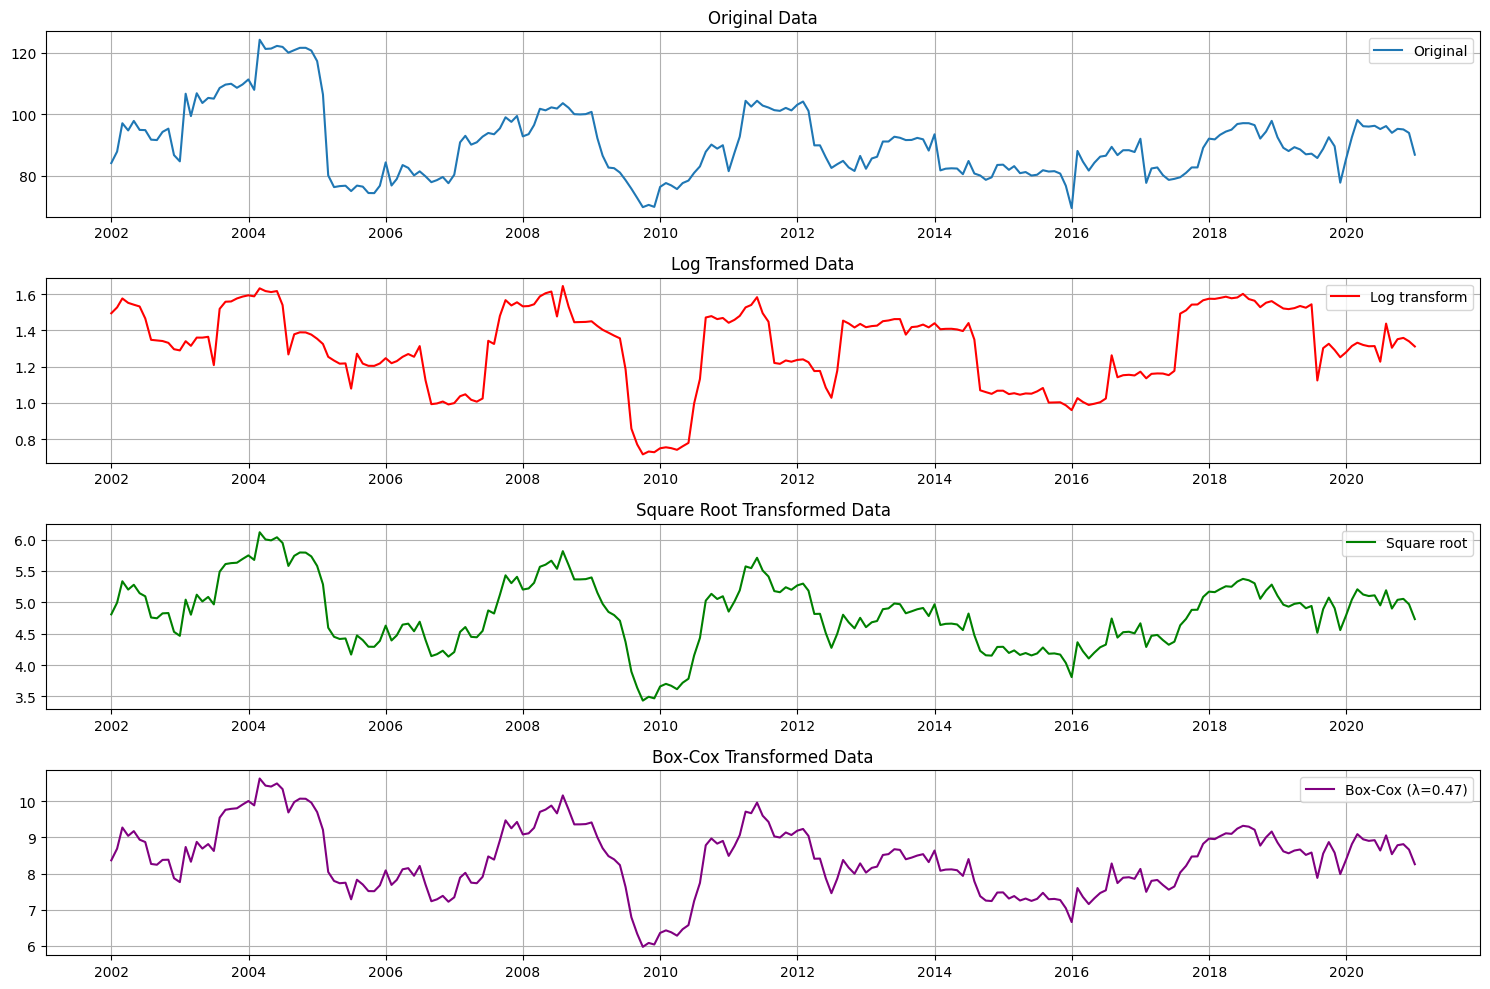

In [23]:
# Log transform
log_data = np.log1p(data['prcp'])  # log1p để tránh log(0)

# Square root transform  
sqrt_data = np.sqrt(data['prcp'])

# Box-Cox transform
from scipy import stats
transformed_data, lambda_param = stats.boxcox(data['prcp'] + 1)

# So sánh rolling STD của các phương pháp
plt.figure(figsize=(15, 10))

plt.subplot(411)
plt.plot(data.index, data['prcp'].rolling(window=12).std(), label='Original')
plt.title('Original Data')
plt.legend()
plt.grid(True)

plt.subplot(412)
plt.plot(data.index, log_data.rolling(window=12).std(), label='Log transform', color='red')
plt.title('Log Transformed Data') 
plt.legend()
plt.grid(True)

plt.subplot(413)
plt.plot(data.index, sqrt_data.rolling(window=12).std(), label='Square root', color='green')
plt.title('Square Root Transformed Data')
plt.legend()
plt.grid(True)

plt.subplot(414)
plt.plot(data.index, pd.Series(transformed_data).rolling(window=12).std(), 
         label=f'Box-Cox (λ={lambda_param:.2f})', color='purple')
plt.title('Box-Cox Transformed Data')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

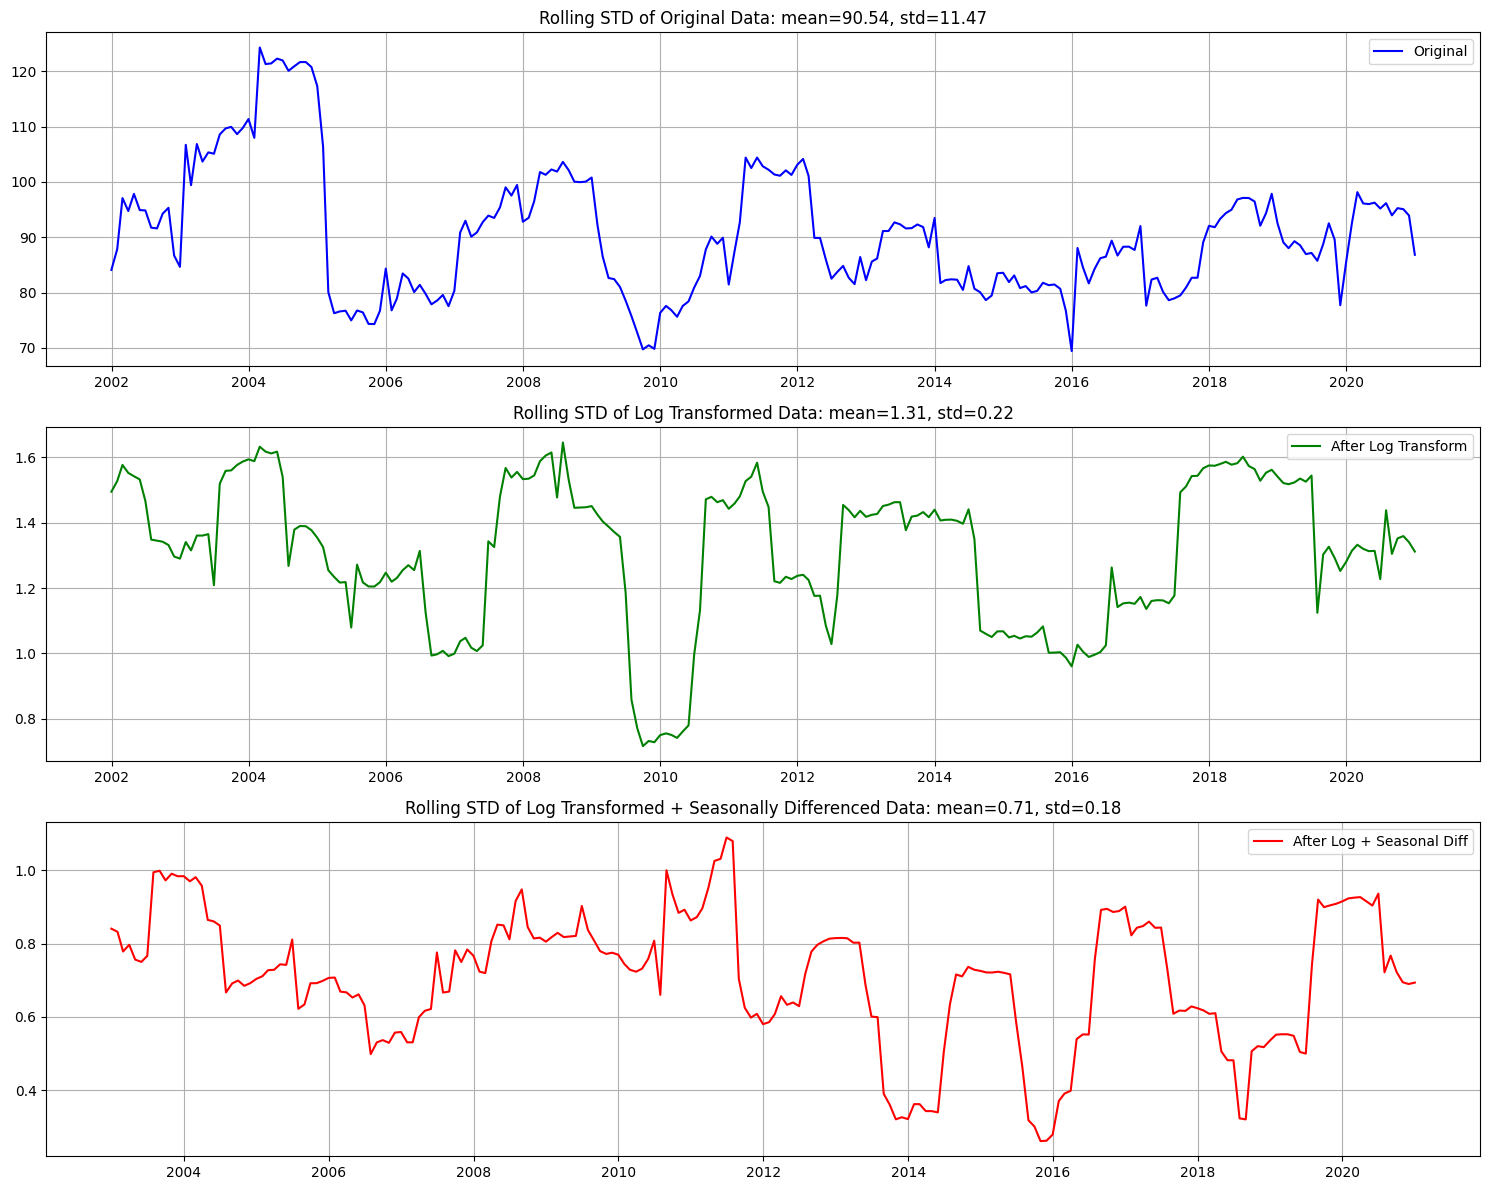


Rolling STD Summary:
Original - Mean: 90.54, STD: 11.47
Log Transform - Mean: 1.31, STD: 0.22
Log + Seasonal Diff - Mean: 0.71, STD: 0.18


In [ ]:
# 1. First apply log transform
log_data = np.log1p(data['prcp'])  # log1p to avoid log(0)

# 2. Then apply seasonal differencing on the log-transformed data
log_seasonal_diff = log_data - log_data.shift(12)
log_seasonal_diff = log_seasonal_diff.dropna()

# Plot comparison of rolling STDs
plt.figure(figsize=(15, 12))

# Original data
plt.subplot(311)
plt.plot(data.index, data['prcp'].rolling(window=12).std(), 
         label='Original', color='blue')
plt.title(f"Rolling STD of Original Data: mean={data['prcp'].rolling(window=12).std().mean():.2f}, std={data['prcp'].rolling(window=12).std().std():.2f}")
plt.legend()
plt.grid(True)

# Log transformed data
plt.subplot(312)
plt.plot(log_data.index, log_data.rolling(window=12).std(),
         label='After Log Transform', color='green')
plt.title(f"Rolling STD of Log Transformed Data: mean={log_data.rolling(window=12).std().mean():.2f}, std={log_data.rolling(window=12).std().std():.2f}")
plt.legend()
plt.grid(True)

# Combined log transform and seasonal differencing
plt.subplot(313)
plt.plot(log_seasonal_diff.index, log_seasonal_diff.rolling(window=12).std(),
         label='After Log + Seasonal Diff', color='red')
plt.title(f"Rolling STD of Log Transformed + Seasonally Differenced Data: mean={log_seasonal_diff.rolling(window=12).std().mean():.2f}, std={log_seasonal_diff.rolling(window=12).std().std():.2f}")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('stationary_check/rolling_std_log_differencing.jpg')
plt.show()

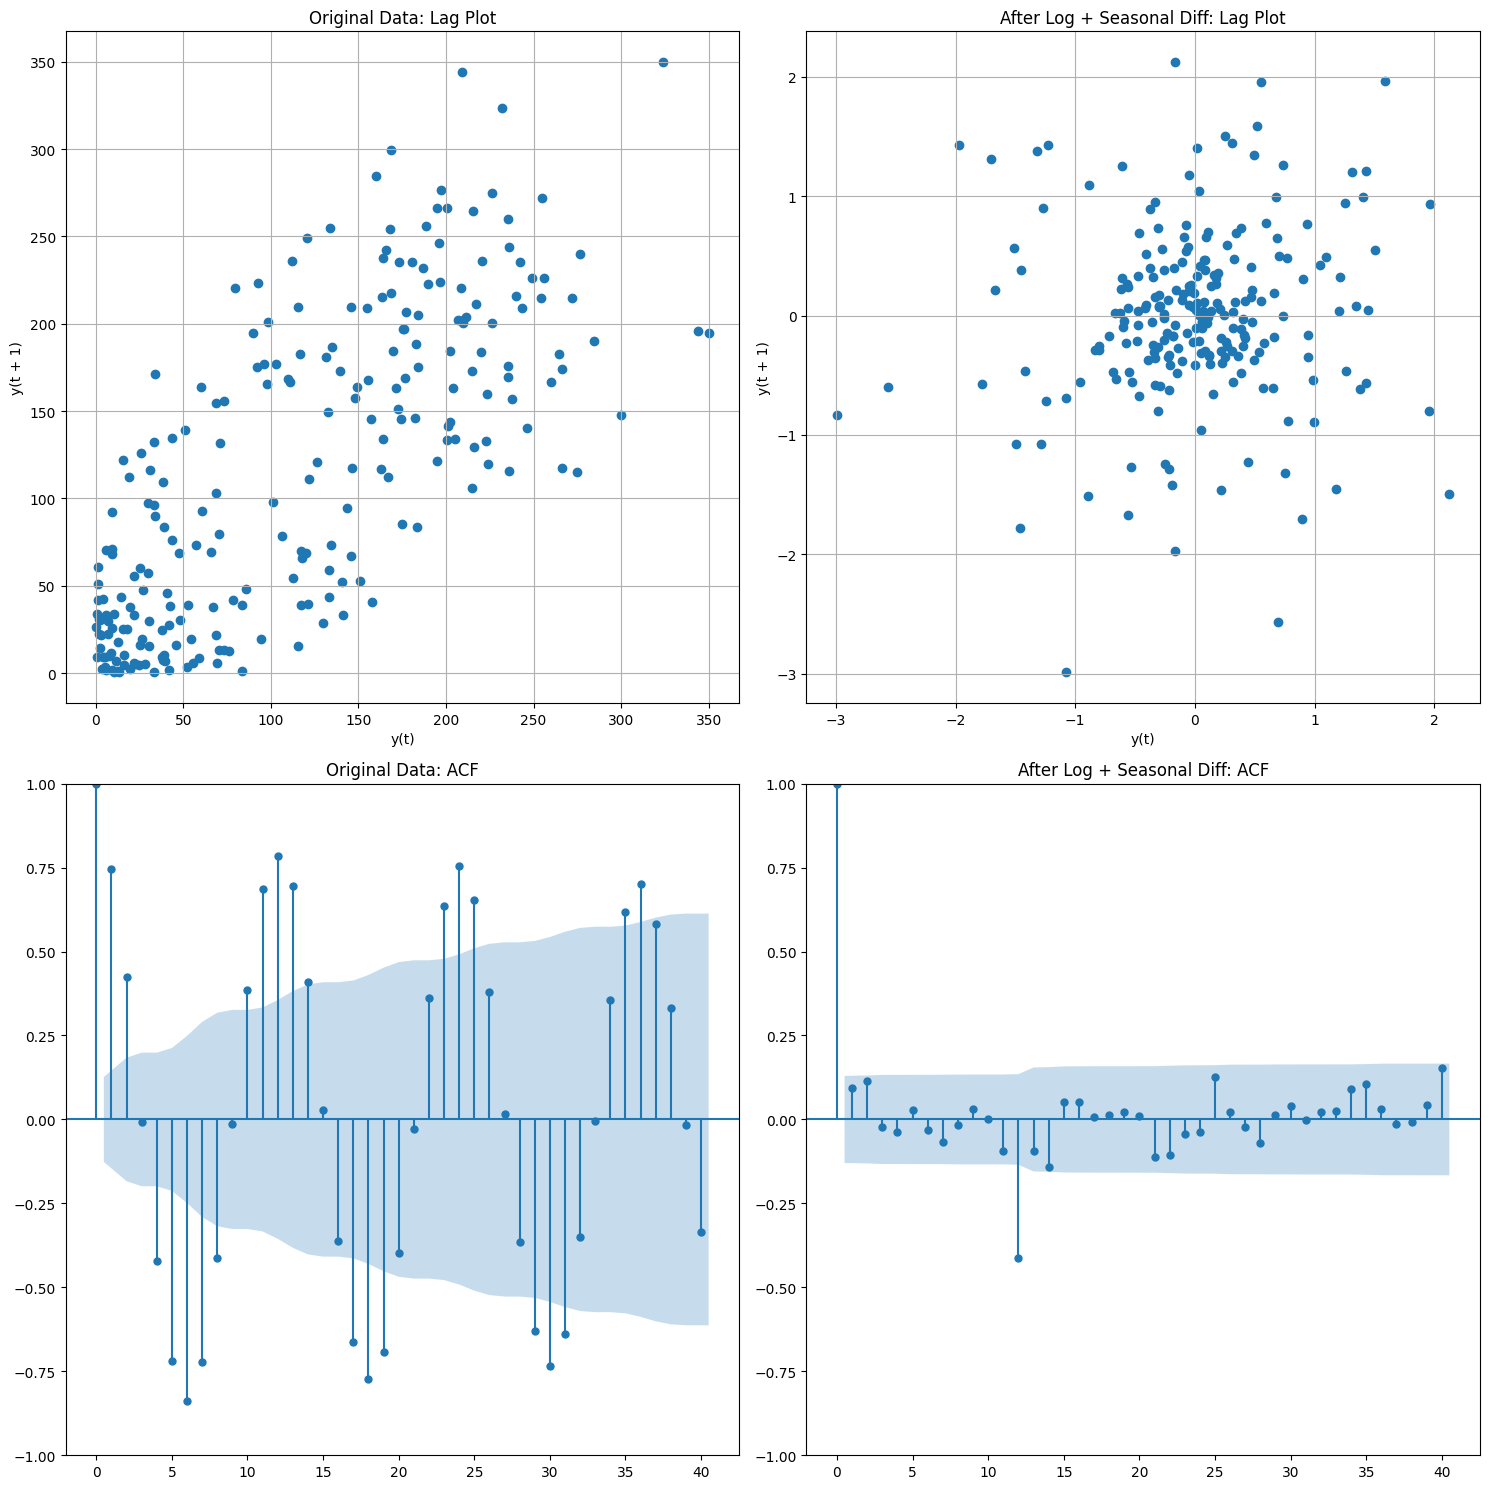

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Lag plots
lag_plot(data['prcp'], ax=ax1)
ax1.set_title('Original Data: Lag Plot')
ax1.grid(True)

lag_plot(log_seasonal_diff, ax=ax2)
ax2.set_title('After Log + Seasonal Diff: Lag Plot') 
ax2.grid(True)

# ACF plots
plot_acf(data['prcp'], ax=ax3, lags=40)
ax3.set_title('Original Data: ACF')

plot_acf(log_seasonal_diff, ax=ax4, lags=40)
ax4.set_title('After Log + Seasonal Diff: ACF')

plt.tight_layout()
plt.savefig('stationary_check/correlation_comparison.jpg')
plt.show()

In [ ]:
def run_stationarity_tests(series, title):
    print(f"\n=== {title} ===")
    
    # ADF Test
    adf_result = adfuller(series.dropna())
    print('\nADF Test:')
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print('Critical values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:.4f}')
        
    # KPSS Test
    kpss_result = kpss(series.dropna())
    print('\nKPSS Test:')
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')
    print('Critical values:')
    for key, value in kpss_result[3].items():
        print(f'\t{key}: {value:.4f}')

run_stationarity_tests(log_seasonal_diff, "Log + Seasonal Differenced Data")


=== Log + Seasonal Differenced Data ===

ADF Test:
ADF Statistic: -7.2445
p-value: 0.0000
Critical values:
	1%: -3.4610
	5%: -2.8750
	10%: -2.5740

KPSS Test:
KPSS Statistic: 0.0285
p-value: 0.1000
Critical values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390

Interpretation:
- ADF Test: H0 = series is non-stationary
- KPSS Test: H0 = series is stationary
For stationarity, we want:
  * ADF: reject H0 (small p-value)
  * KPSS: fail to reject H0 (large p-value)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1764\2090256574.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna())
